# Order parameters

## Graph structure

All edges are stored in a list of sets $edgelist$ such that each of them has a label corresponding to its position. At the same position in the list $X$ are stored the order parameters into a list of $8$ elements. Test: $X$ is now a dictionary

1) ring participation
Two integers: 0 if no ring, number of ring members if a closed ring
(0, 4,5,6,7... 12)

2) Other rings that p1, and p2 are a part of: 1 integer for p1, 1 for p2. Since there is only up to one extra ring per particle

3) number of bonded neighbors of the two particles (p1, p2) involved
Two integers: (1,2,3)

4) Local connectivity parameters
- Average number of bonds per neighbor of p1 and p2. (2 real number)

5) Number particles within a radius of $r$ from the center of the bond (1 integer number)

6) Concavity of the rings (+1 for each concave ring)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import copy
import time as tm
from sys import exit
from numpy.linalg import norm

In [3]:
l = 0
C=[]
d=500; e=85
sname="snap."+str(e)+"."+str(d)+".patch"
lname="breaklist_"+str(e)+"."+str(d)+".dat"
with open(sname, "r") as snap:   #particle positions
    for line in snap:
        if l==0:
            N = int(line[1:])
            l=l+1
        elif l==1:
            tmp=[x for x in line.split()]
            xsize, ysize = float(tmp[0]), float(tmp[1])
            l=l+1
        else:
            tmp=[x for x in line.split()]
            #C.append([rescale(float(tmp[1]), xsize), rescale(float(tmp[2]), ysize)])
            C.append([float(tmp[1]), float(tmp[2])])
            
l = 0
events=[]
with open(lname, "r") as file:  #Breaking Times
    for line in file:
        if l==0:
            l=l+1
        elif l==1:
            tmp=[x for x in line.split()]
            time = float(tmp[-1])
            l=l+1
        else:
            tmp=[x for x in line.split()]
            events.append([int(tmp[0]), int(tmp[1]), float(tmp[3])])

events=np.array(events)

C_ind=[[C[i][0]]+[i] for i in range(len(C))]
#C_sort=sorted([list(nearestimage(c)) for c in C], key=lambda a: a[0])
C_sort=sorted(C, key=lambda a: a[0])
C=np.array(C)

In [31]:
def rescale(x, M=xsize):
    if x>M/2:
        return rescale(x-M, M)
    elif x<-M/2:
        return rescale(x+M, M)
    else:
        return x
    
def nearestimage(v):
    return np.array([rescale(v[0], xsize), rescale(v[1],ysize) ])

dirs=["s", "d"]

def S(v):
    for i in range(1,len(v)+1):
        if v[-i]==v[0]: v = v[-i:];break
    if len(v)==1: return list(v)
    return [v[0]]+S(v[1:])

def cleancycle(v):
    return [v[0]]+S(v[1:-1])+[v[-1]]

def bondafter(topart, frompart, direction): #next bond if I keep turning left
    ang = []
    global concavity
    for i in G[topart]:
        dr=nearestimage(C[i]-C[topart])
        ang.append([i, np.arctan2(dr[1],dr[0])])
    ang = sorted(ang, key=lambda a: a[1]) #left direction
    if direction=="d": ang.reverse()
    
    for i in range(len(ang)):
        if ang[i][0] == frompart:
            #This should mean an angle out of [0,\pi]
            c=(rescale(ang[i-1][0]-ang[i][0], 2*np.pi)<0and direction=="s") or (rescale(ang[i-1][0]-ang[i][0], 2*np.pi)>0and direction=="d")
            if c: concavity=1
            return ang[i-1][0]
    return -1

def cycle(i, j, direction):
    i,j=sorted((i,j))
        
    if frozenset({i,j, direction}) in P: return P[frozenset({i,j, direction})]
    
    loop = [i, j]
    global concavity
    concavity=0
    while (loop[-1] != loop[0]):
        loop.append(bondafter(loop[-1], loop[-2], direction))
        
    loop = cleancycle(loop)
    l=len(loop)
    if l<4: P[frozenset({i, j, direction})]=(0, set(), 0); return (0, set(), 0) #no ring is convex as convetion
    for v in range(l-1):
        td=0 if loop[v]<loop[v+1] else 1
        turn=dirs[dirs.index(direction)- td]  #set the direction as convention
        if frozenset({loop[v], loop[v+1], turn}) not in P:
            P[frozenset({loop[v], loop[v+1], turn})]=(l-1, set(loop), concavity)
    #print(loop)
    return P[frozenset({i, j, direction})]

def distance(r,s):
    r,s=np.array(r), np.array(s)
    if r.size == 2 : return norm(nearestimage(r-s))
    else : return np.abs(rescale(r-s))
    
def rneighbors(i, j, r=2):
#     print(C[i], C[j])
    m = C[i] + nearestimage(C[j]-C[i])/2
#     print(">>", m)
    c, t, di = 1, 0, 1 #the 1st is already counted
    start=C_sort.index(list(C[i]))
    while t <r:
#         d1=distance(m, np.array(C_sort[(start+di)%N]))
#         print(d1)
        if distance(m, np.array(C_sort[(start+di)%N]))<r: c += 1
        if distance(m, np.array(C_sort[(start-di)%N]))<r: c += 1 #even C_sort[-something] to consider boundary conditions
        di += 1
        t = np.min((distance(m[0], C_sort[(start+di)%N][0]), distance(m[0], C_sort[(start-di)%N][0])))
#     print(c)
    return c

In [5]:
i,j= 49, 847
#rneighbors(i, j)
m = (C[i]+C[j])/2
start=C_sort.index(list(C[i]))
print(C[i], C_sort[start])
print(m)
#print(distance(m, C[i]), distance(m, C_sort[start]))
#distance(m, C[i])
np.linalg.norm(nearestimage(np.abs(m-C[i])))

[41.442517 53.837949] [41.442517, 53.837949]
[41.1501745 27.1749285]


26.664623123545674

In [9]:
rneighbors(i,j)

12

In [11]:
G=[set() for i in range(N)]
edgelist=[]
y=[]

for evs in events:
    ev = evs[:-1]
    edgelist.append(set(ev))
    G[int(ev[0])].add(int(ev[1]))
    G[int(ev[1])].add(int(ev[0]))
    y.append(evs[-1])
    
wc_idx = np.argmin(y)
opt_time=y[wc_idx]
errors = time/(np.array(y))**1.5

print("Worst case error: %.3f"% errors[wc_idx])
y = time/np.array(y)
t_b = (((y-np.mean(y))/np.std(y))+1)/2

opt_time=opt_time*y[wc_idx]
y = y/np.mean(y)
print("Optimal time: %.3f"% opt_time)

Worst case error: 2.612
Optimal time: 100000.000


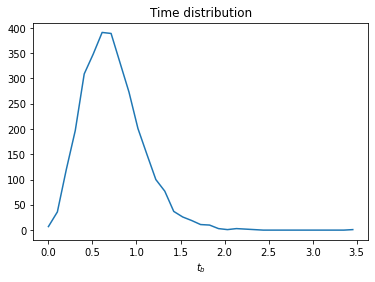

In [12]:
H=np.histogram(y, bins=35)
plt.plot(np.linspace(0, H[1][-1], H[0].size), H[0])
plt.title("Time distribution")
plt.xlabel("$t_b$")
plt.show()

In [32]:
#NEW
X = np.array([-1*np.ones(10) for i in range(len(edgelist))])
P= dict()
t0= tm.time()
for i in range(N):
    avg = 0
    if len(G[i]) == 0: continue
    for j in G[i]:
        e_idx = edgelist.index({i,j}) 
        if i<j:
            X[e_idx][0], p1, c1 = cycle(i, j, "s")                                   #finds left ring
            r2, p2, c2 = cycle(i, j, "d")                                            #finds right ring
            X[e_idx][1]=r2 if p1 != p2 else 0.
            
            if X[e_idx][0]*X[e_idx][1] != 0:                   #finds the extra ones only if the prev exist
                Di = next(v for v in p1 if v in G[i] and v!=j) #NN of i in the loop
                Dj = next(v for v in p1 if v in G[j] and v!=i) #NN of j in the loop
                
                if len(G[i]) == 3:
                    direct = "s" if i<Di else "d"
                    r3, p3 = cycle(i, Di, direct)[:-1]
                    X[e_idx][2] = r3 if (p3 !=p1 and p3 !=p2) else 0
                else: X[e_idx][2]=0
                    
                if len(G[j]) == 3:
                    direct = "d" if i<Di else "s"
                    r4, p4 = cycle(j, Dj, direct)[:-1]
                    X[e_idx][3] = r4 if (p4 !=p1 and p4 !=p2) else 0
                else: X[e_idx][3]=0
            else:
                X[e_idx][2:4] = np.zeros(2)

            X[e_idx][4:6] = np.array([len(G[i]), len(G[j])])
            X[e_idx][8] = rneighbors(i,j)
            X[e_idx][9] = c1+c2
        avg += len(G[j])
        
    avg /= len(G[i])                                                             #finds 3
    
    for j in G[i]:
        idx= 7 if i>j else 6
        X[edgelist.index({i,j})][idx] = avg                                      #finds 4
        
print(tm.time()-t0)

13.41357159614563


In [74]:
def cleanx(x):
    return 16 if (x==0 or x>15) else x

X[:, 0:4]=[[cleanx(i) for i in x] for x in X[:, 0:4]]

[0. 1. 2.]


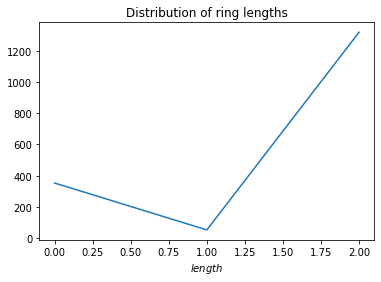

In [33]:
l,occ=np.unique(X[:,9], return_counts=True)
occ[1:]=occ[1:]/l[1:]
plt.plot(l, occ)
print(l)
plt.title("Distribution of ring lengths")
plt.xlabel("$length$")
plt.show()

# Learning parameters

In [16]:
#Importing the relevant parts of pytorch
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import pandas as pd
import seaborn as sb


#This is for printing some progress
from IPython.display import clear_output
torchX=torch.from_numpy(X).float()
torchy=torch.from_numpy(y).float().unsqueeze(1)

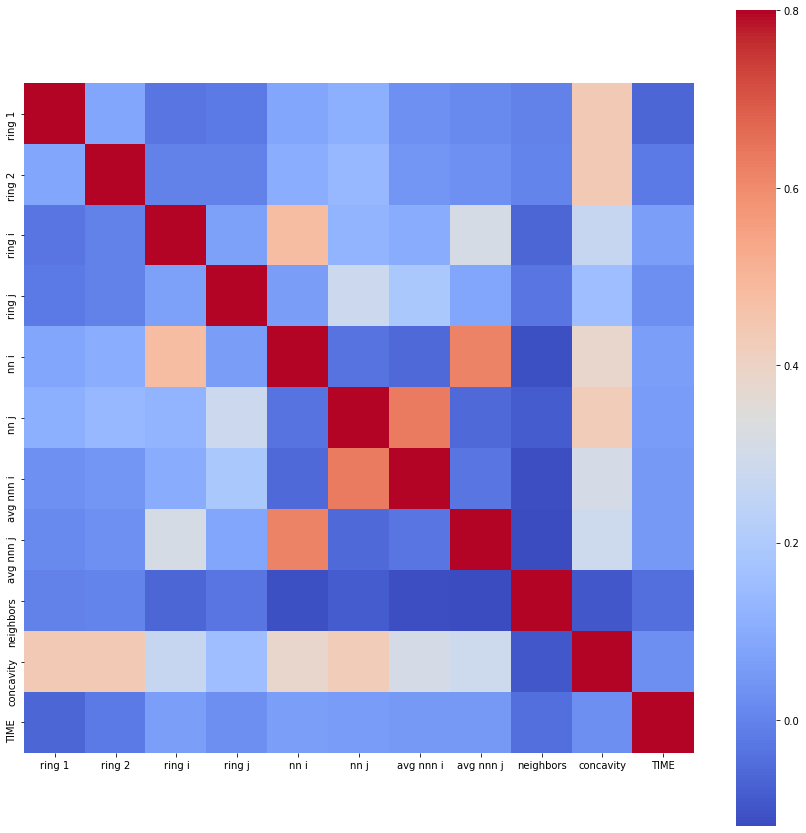

In [35]:
DF=np.hstack((X,np.atleast_2d(y).T))
DF=pd.DataFrame(DF)
DF.columns = ["ring 1", "ring 2", "ring i", "ring j", "nn i", "nn j", "avg nnn i", "avg nnn j", "neighbors", "concavity", "TIME"]
#DF.columns = ["ring 1", "ring 2", "ring i", "ring j", "nn i", "nn j", "avg nnn i", "avg nnn j", "neighbors", "TIME"]
#DF.index=[str(e) for e in edgelist]

C_mat = DF.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True, cmap="coolwarm")
plt.show()

In [176]:
def test_train_split(X, y, test_fraction, shuffle=True):
    d_size = len(X)
    indices = list(range(d_size))
    split = int(np.floor(test_fraction*d_size))
    if shuffle:
        np.random.seed(1)
        np.random.shuffle(indices)
    train_indices, test_indices = indices[split:], indices[:split]
    return (X[train_indices], y[train_indices], X[test_indices], y[test_indices], test_indices)

def accuracy(model, X, y, pct_close):
    n=len(y)
    n_correct = torch.sum(torch.abs(model(X)-y)<torch.abs(pct_close*y))
    return n_correct.item()*100./n

In [177]:
#Set a fixed seed, since we're testing things
torch.manual_seed(1)    # reproducible

In [178]:
X_train, y_train, X_test, y_test, tests=test_train_split(torchX,torchy, .2)

### Neural Network

In [179]:
#One way to define a network
net = torch.nn.Sequential(
        torch.nn.Linear(9, 20),
        torch.nn.Tanh(),
        torch.nn.Linear(20, 8),
        torch.nn.Tanh(),
        torch.nn.Linear(8, 1),
    )

#Normalize
def normalize(X):
    for i in range(X.shape[1]):
        m=X[:,i].mean(0)
        std=X[:,i].std(0)
        X[:,i]=(X[:,i]-m)/std
        X[:,i]=(X[:,i]+1)/2
    return X

#Optimizer: Adam
optimizer = torch.optim.Adam(net.parameters(), lr=0.01) 

#Stochastic Gradient Descent is another option
#optimizer =  torch.optim.SGD(net.parameters(), lr = 0.05, momentum=0.9, weight_decay=1e-5)

loss_func = torch.nn.MSELoss()  # this is our loss function: mean squared error

In [180]:
# train the network
# You can run this cell multiple times, or just change the number of steps.
# I get decent results after ~10000 steps.
# Given the current size of the dataset, we may be overfitting...
for t in range(6000):
  
    prediction = net(X_train)     # input x and predict based on x

    loss = loss_func(prediction, y_train)     # must be (1. nn output, 2. target)

    #Print loss each cycle to keep track, after clearing the previous print statements
    clear_output(wait=True)
    print(t, loss.data.numpy())

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
# plot current status: prediction versus real value
tt = np.arange(0.5,2., 0.2)

5999 0.06754853


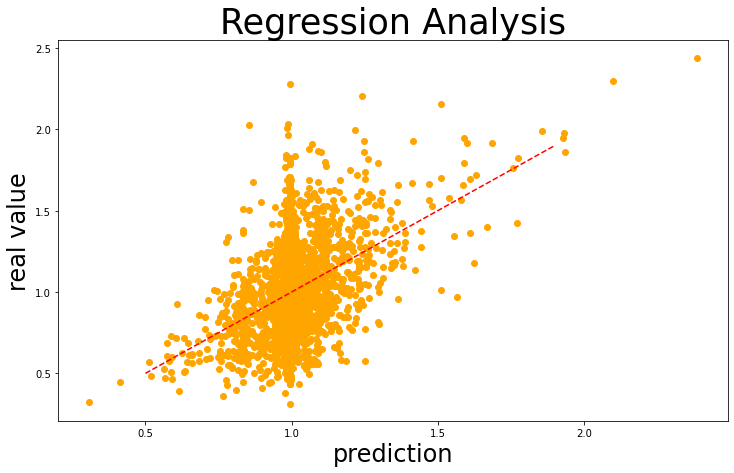

(44.23) Accuracy of 39.31 %


In [181]:
fig, ax = plt.subplots(figsize=(12,7))
ax.set_title('Regression Analysis', fontsize=35)
ax.set_xlabel('prediction', fontsize=24)
ax.set_ylabel('real value', fontsize=24)
plt.scatter(prediction.data.numpy(), y_train.data.numpy(), color = "orange")
# Dashed line is the ideal result
plt.plot(tt,tt,'r--')
plt.show()

tr_acc=accuracy(net, X_train, y_train, .15)
acc=accuracy(net, X_test, y_test, .15)
print("(%.2f) Accuracy of %0.2f %%" % (tr_acc, acc))

### Error analysis

In [182]:
import matplotlib.pylab as pl
from matplotlib import gridspec

def vmap(p, cmap):
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    p.imshow([colors], extent=[0, 1, 0, .1])
    p.get_yaxis().set_visible(False)

In [183]:
net_err = (net(torchX)-torchy)**2
#net_err = ((net_err - net_err.mean(0))/net_err.std(0)+1)/2
net_err = normalize(net_err)
net_err = np.squeeze(net_err.data.numpy())

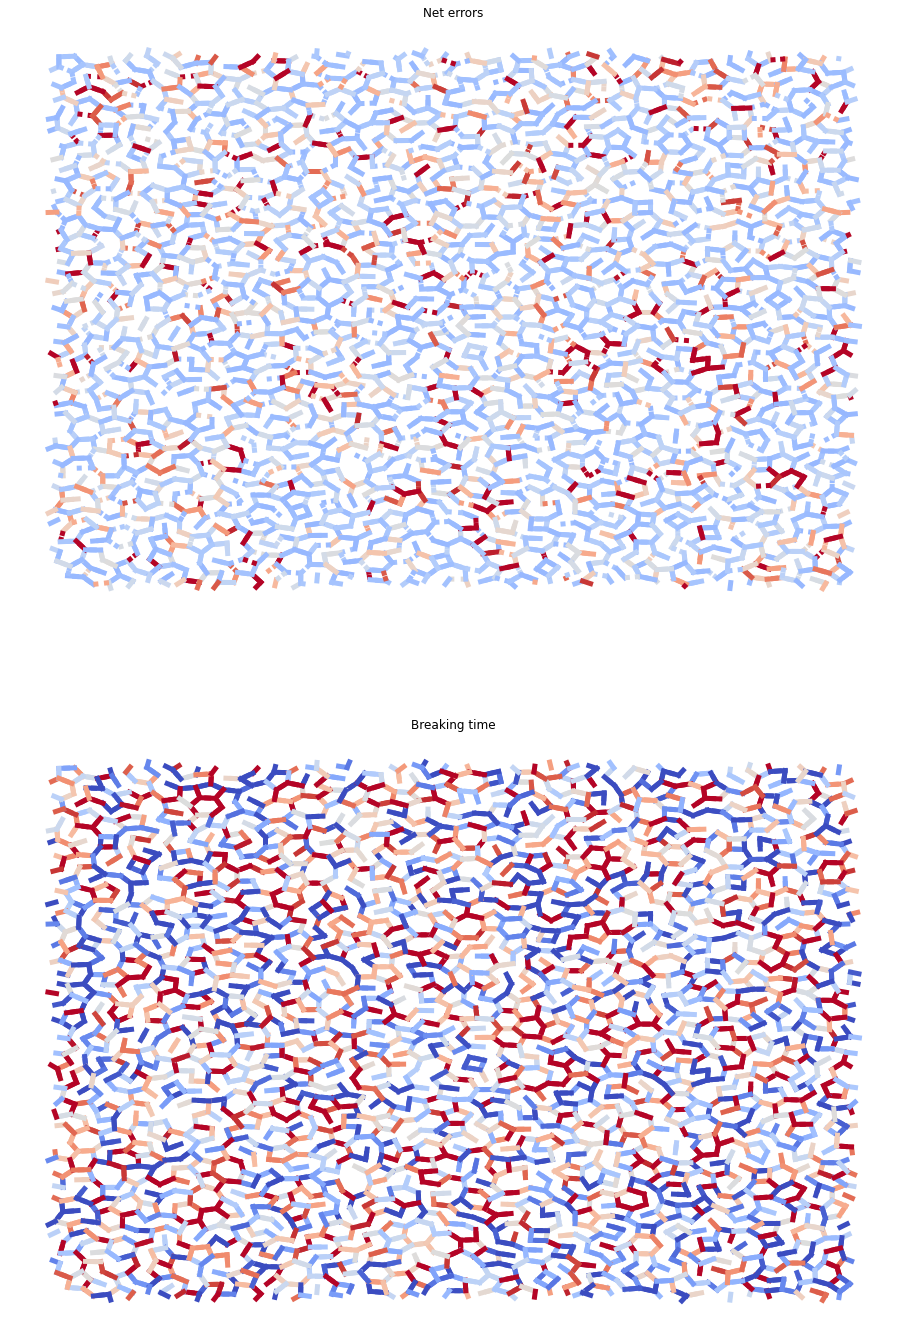

In [184]:
fig, ax = plt.subplots(2,1, figsize=(16, 24))
ax[0].axis("off")
ax[1].axis("off")
δ = .6
ax[0].set_title("Net errors")
ax[1].set_title("Breaking time")
for ev in range(events[:,2].size):   #Bonds
    col = pl.cm.coolwarm(net_err[ev])
    r1 = np.array(C[int(events[ev,0])][:])
    r2 = np.array(C[int(events[ev,1])][:])
    dr = [rescale((r2 - r1)[0], xsize), rescale((r2-r1)[1], ysize)]
    line=':' if ev in tests else '-'
    col = pl.cm.coolwarm(net_err[ev])
    ax[0].plot([r1[0], r1[0]+δ*dr[0]/np.linalg.norm(dr)], [r1[1], r1[1]+δ*dr[1]/np.linalg.norm(dr)], color=col, linewidth=5, zorder=1, ls=line)
    ax[0].plot([r2[0], r2[0]-δ*dr[0]/np.linalg.norm(dr)], [r2[1], r2[1]-δ*dr[1]/np.linalg.norm(dr)], color=col, linewidth=5, zorder=1, ls=line)
    
    col = pl.cm.coolwarm(t_b[ev])
    ax[1].plot([r1[0], r1[0]+δ*dr[0]/np.linalg.norm(dr)], [r1[1], r1[1]+δ*dr[1]/np.linalg.norm(dr)], color=col, linewidth=5, zorder=1)
    ax[1].plot([r2[0], r2[0]-δ*dr[0]/np.linalg.norm(dr)], [r2[1], r2[1]-δ*dr[1]/np.linalg.norm(dr)], color=col, linewidth=5, zorder=1)
    
#ax0.scatter(C[:,0], C[:,1], s=100, zorder=2)   #Particles

#ax1=plt.subplot(gs[1])
#vmap(ax1,'coolwarm')

plt.show()